<a href="https://colab.research.google.com/github/walkidni/grayscale-image-colorization/blob/main/CIFAR100unet_colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/colorization'

Mounted at /content/drive
/content/drive/MyDrive/colorization


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, RandomSampler
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm
from PIL import Image
from skimage import color
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# I. Data preparation

## 0. utils

In [ ]:

def stack_lab(l, ab):
  return torch.cat((l, ab))

def lab2rgb(lab, to_numpy):
  if lab.requires_grad :
    lab = lab.detach()
  lab = lab.permute((1,2,0))
  rgb = color.lab2rgb(lab)
  if to_numpy:
    return rgb
  else:
    return torch.from_numpy().permute(2,0,1)

def to_rgb(l, ab, to_numpy=True):
  lab = stack_lab(l,ab)
  rgb = lab2rgb(lab, to_numpy = to_numpy)
  return rgb

## 1. using CIFAR100

In [ ]:
class ColorizationDataset(Dataset):
    def __init__(self,root='./data', train=True, resize=None):
        self.cifar100 = datasets.CIFAR100(root=root, train=train, download=True)
        self.resize = resize

    def __len__(self):
        return len(self.cifar100)

    def __getitem__(self, index):
        image, label = self.cifar100[index]
        if self.resize:
          image = image.resize((self.resize, self.resize))

        lab_image = color.rgb2lab(image)
        lab_image = lab_image.astype(np.float32)
        L, ab = lab_image[:,:,0], lab_image[:,:,1:]
        L = torch.from_numpy(L).unsqueeze(dim=0)
        ab = torch.from_numpy(ab).permute((2,0,1))

        return L, ab

In [ ]:
train_data = ColorizationDataset(
    root='./data',
    train=True,
    resize = None
)

test_data = ColorizationDataset(
    root='./data',
    train=False,
    resize = None
)
len(train_data), len(test_data)


100%|██████████| 169001437/169001437 [00:03<00:00, 42360808.52it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


(50000, 10000)

In [ ]:
gray, chrome = train_data[69]
gray.shape, chrome.shape

(torch.Size([1, 32, 32]), torch.Size([2, 32, 32]))

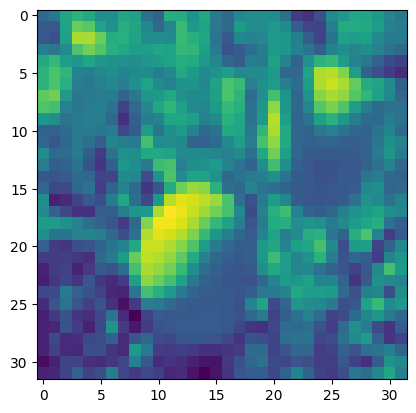

In [ ]:
plt.imshow(gray[0])

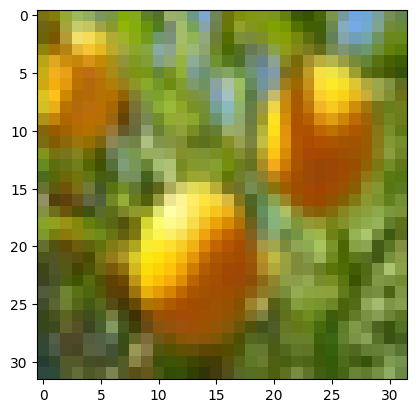

In [ ]:
rgb = to_rgb(gray, chrome)
plt.imshow(rgb)

# II. Preparing the Model

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=True, leaky=0.2):
        super().__init__()
        self.batch_norm = batch_norm
        self.leaky = leaky
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        if self.batch_norm:
          self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = nn.LeakyReLU(self.leaky)(self.conv1(x))
        x = nn.LeakyReLU(self.leaky)(self.conv2(x))
        if self.batch_norm:
          x = self.bn(x)
        return x


In [ ]:
class DecoderConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # output_size = (input_size - 1) * stride + kernel_size - 2 * padding
        self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2) 
        self.conv = DoubleConv(out_channels + out_channels, out_channels, batch_norm=False)

    def forward(self, x, x1):
        y1 = self.up_conv(x)
        y2 = torch.cat((y1, x1), dim=-3)
        y = self.conv(y2)
        return y

In [ ]:
class UNet(nn.Module):
    def __init__(self, size):
        super().__init__()

        # non trainable layers
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # trainable layers
        ## encoder 
        self.en_conv1 = DoubleConv(1,size)
        self.en_conv2 = DoubleConv(size,size*2)
        self.en_conv3 = DoubleConv(size*2,size*4)
        self.en_conv4 = DoubleConv(size*4,size*8)
        
        ## bottleneck
        self.conv = DoubleConv(size*8,size*16)
        self.drop = nn.Dropout(0)

        ## decoder
        self.de_conv4 = DecoderConv(size*16,size*8)
        self.de_conv3 = DecoderConv(size*8,size*4)
        self.de_conv2 = DecoderConv(size*4,size*2)
        self.de_conv1 = DecoderConv(size*2,size)
        
        ## reconstruct layer
        self.reconstruct = nn.Conv2d(size, 2, kernel_size=3, padding=1)

    def forward(self, x):
      # encoder inference 
        e1 = self.en_conv1(x)
        p1 = self.pool(e1)
        
        e2 = self.en_conv2(p1)
        p2 = self.pool(e2)
        
        e3 = self.en_conv3(p2) 
        p3 = self.pool(e3)
        
        e4 = self.en_conv4(p3)
        p4 = self.pool(e4)

      # bottleneck inference
        b = self.drop(self.conv(p4))

      # decoder inference 
        d4 = self.de_conv4(b,e4)

        d3 = self.de_conv3(d4,e3)

        d2 = self.de_conv2(d3,e2)

        d1 = self.de_conv1(d2,e1)



      # reconstruct image
        colored_image = self.reconstruct(d1)
        # print(colored_image.shape)


        
        return colored_image

# III. Training 

In [ ]:
# Training loop
def train(model, trainloader, criterion, optimizer, progress_bar):
    model.train()
    running_loss = 0.0

    for grayscale_images, colored_images in progress_bar:
        grayscale_images = grayscale_images.to(device)
        colored_images = colored_images.to(device)
        optimizer.zero_grad()

        # Forward pass
        predicted_images = model(grayscale_images)

        # Compute the loss
        loss = criterion(predicted_images, colored_images)

        # Backpropagation and weight updates
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss
    average_loss = running_loss / len(trainloader)

    return average_loss, loss

# Evaluation loop
def evaluate(model, testloader, criterion, progressbar):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for grayscale_images, colored_images in progressbar:
            grayscale_images = grayscale_images.to(device)
            colored_images = colored_images.to(device)

            # Forward pass
            predicted_images = model(grayscale_images)

            # Compute the loss
            loss = criterion(predicted_images, colored_images)

            # Accumulate loss
            running_loss += loss.item()

    # Calculate average loss
    average_loss = running_loss / len(testloader)

    return average_loss, loss



In [ ]:

# Training and evaluation loop (to execute multiple times)
batch_size = 256
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


# Set up training parameters
lr = 0.001

# Initialize your U-Net model
model = UNet(32)
model.to(device)

# Define loss function and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr)

num_epochs = 200
train_losses = []
validation_losses = []
for epoch in tqdm(range(num_epochs)):
    print(f'Epoch {epoch+1}/{num_epochs}:', end='  ')
    pbar = tqdm(train_loader, leave=False)
    pbar.set_description(f'Train {epoch+1}/{num_epochs}')
    train_loss = train(model, train_loader, criterion, optimizer, pbar)
    print(f"f'Epoch {epoch+1}/{num_epochs}:  Train Loss: {train_loss}", end='  ')

    evalbar = tqdm(test_loader, leave=False)
    evalbar.set_description(f'Val {epoch+1}/{num_epochs}')
    val_loss = evaluate(model, test_loader, criterion, evalbar)
    print(f"Validation Loss: {val_loss}")
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)


Epoch 1/200:  

Train Loss: 10.331429968074877  

Validation Loss: 10.241308236122132
Epoch 2/200:  

Train Loss: 10.085317314887533  

Validation Loss: 10.163974905014038
Epoch 3/200:  

Train Loss: 9.963521913606293  

Validation Loss: 10.037358021736145
Epoch 4/200:  

Train Loss: 9.89017188792326  

Validation Loss: 10.116789770126342
Epoch 5/200:  

Train Loss: 9.818479299545288  

Validation Loss: 9.766467595100403
Epoch 6/200:  

Train Loss: 9.741599910113276  

Validation Loss: 9.805508995056153
Epoch 7/200:  

Train Loss: 9.697554111480713  

Validation Loss: 9.912169408798217
Epoch 8/200:  

Train Loss: 9.660385384851573  

Validation Loss: 9.6672931432724
Epoch 9/200:  

Train Loss: 9.58593781140386  

Validation Loss: 9.74452202320099
Epoch 10/200:  

Train Loss: 9.512462946833397  

Validation Loss: 9.636036705970763
Epoch 11/200:  

Train Loss: 9.459971184633217  

Validation Loss: 9.556094455718995
Epoch 12/200:  

Train Loss: 9.399753492705676  

Validation Loss: 9.581059646606445
Epoch 13/200:  

Train Loss: 9.34327091976088  

Validation Loss: 9.620994377136231
Epoch 14/200:  

Train Loss: 9.287891874507983  

Validation Loss: 9.487795400619508
Epoch 15/200:  

Train Loss: 9.207288888035988  

Validation Loss: 9.668143033981323
Epoch 16/200:  

Train Loss: 9.15208656933843  

Validation Loss: 9.451406455039978
Epoch 17/200:  

Train Loss: 9.082458447436897  

Validation Loss: 9.608175587654113
Epoch 18/200:  

Train Loss: 8.9958253344711  

Validation Loss: 9.412505793571473
Epoch 19/200:  

Train Loss: 8.907056922815284  

Validation Loss: 9.649314022064209
Epoch 20/200:  

Train Loss: 8.825886709349495  

Validation Loss: 9.611247181892395
Epoch 21/200:  

Train Loss: 8.736383678961774  

Validation Loss: 9.495213055610657
Epoch 22/200:  

Train Loss: 8.65163131392732  

Validation Loss: 9.432353949546814
Epoch 23/200:  

Train Loss: 8.531569476030311  

Validation Loss: 9.770016193389893
Epoch 24/200:  

Train Loss: 8.421144959877948  

Validation Loss: 9.871703791618348
Epoch 25/200:  

Train Loss: 8.300793467735758  

Validation Loss: 9.577027654647827
Epoch 26/200:  

Train Loss: 8.199882675190361  

Validation Loss: 9.63218195438385
Epoch 27/200:  

Train Loss: 8.077153283722547  

Validation Loss: 9.671311926841735
Epoch 28/200:  

Train Loss: 7.940138583280603  

Validation Loss: 9.719743394851685
Epoch 29/200:  

Train Loss: 7.858381962289616  

Validation Loss: 9.511680054664613
Epoch 30/200:  

Train Loss: 7.7004488487632905  

Validation Loss: 9.708202672004699
Epoch 31/200:  

Train Loss: 7.602146929624129  

Validation Loss: 9.565399634838105
Epoch 32/200:  

Train Loss: 7.500634205584624  

Validation Loss: 9.594409048557281
Epoch 33/200:  

Train Loss: 7.368958928147141  

Validation Loss: 9.788561034202576
Epoch 34/200:  

Train Loss: 7.249973630418583  

Validation Loss: 9.662257432937622
Epoch 35/200:  

Train Loss: 7.16354327299157  

Validation Loss: 9.837510800361633
Epoch 36/200:  

Train Loss: 7.009933296515017  

Validation Loss: 9.867095255851746
Epoch 37/200:  

Train Loss: 6.934990296558458  

Validation Loss: 9.74789137840271
Epoch 38/200:  

Train Loss: 6.827547379902431  

Validation Loss: 9.625652635097504
Epoch 39/200:  

Train Loss: 6.737914438150367  

Validation Loss: 9.630726742744447
Epoch 40/200:  

Train Loss: 6.644883396674175  

Validation Loss: 9.779645299911499
Epoch 41/200:  

Train Loss: 6.555403456395986  

Validation Loss: 9.730352997779846
Epoch 42/200:  

Train Loss: 6.424382961526209  

Validation Loss: 9.722789740562439
Epoch 43/200:  

Train Loss: 6.33185614128502  

Validation Loss: 9.800356245040893
Epoch 44/200:  

Train Loss: 6.237965167785178  

Validation Loss: 9.66224422454834
Epoch 45/200:  

Train Loss: 6.143221774879767  

Validation Loss: 9.962857842445374
Epoch 46/200:  

Train Loss: 6.084926189208518  

Validation Loss: 9.856109046936036
Epoch 47/200:  

Train Loss: 5.998136340355386  

Validation Loss: 10.063057374954223
Epoch 48/200:  

Train Loss: 5.925444802459405  

Validation Loss: 9.861701345443725
Epoch 49/200:  

Train Loss: 5.85663899110288  

Validation Loss: 10.013302731513978
Epoch 50/200:  

Train Loss: 5.769847906365687  

Validation Loss: 9.65970344543457
Epoch 51/200:  

Train Loss: 5.685458633364464  

Validation Loss: 9.926033520698548
Epoch 52/200:  

Train Loss: 5.597443150014294  

Validation Loss: 10.007901501655578
Epoch 53/200:  

Train Loss: 5.559245802918259  

Validation Loss: 9.806408333778382
Epoch 54/200:  

Train Loss: 5.486665273199276  

Validation Loss: 9.807391953468322
Epoch 55/200:  

Train Loss: 5.424115519134366  

Validation Loss: 9.866724348068237
Epoch 56/200:  

Train Loss: 5.345363108479247  

Validation Loss: 9.740303826332092
Epoch 57/200:  

Train Loss: 5.310982740655238  

Validation Loss: 9.770308828353881
Epoch 58/200:  

Train Loss: 5.24284024384557  

Validation Loss: 9.85785174369812
Epoch 59/200:  

Train Loss: 5.197406780963042  

Validation Loss: 9.916268658638
Epoch 60/200:  

Train Loss: 5.159304421775195  

Validation Loss: 9.94634394645691
Epoch 61/200:  

Train Loss: 5.096723223219112  

Validation Loss: 9.853208947181702
Epoch 62/200:  

Train Loss: 5.043675449429726  

Validation Loss: 9.887517976760865
Epoch 63/200:  

Train Loss: 4.989396467500804  

Validation Loss: 9.910396385192872
Epoch 64/200:  

Train Loss: 4.969352945989492  

Validation Loss: 9.81198353767395
Epoch 65/200:  

Train Loss: 4.879930810052521  

Validation Loss: 9.936369895935059
Epoch 66/200:  

Train Loss: 4.857979652832966  

Validation Loss: 10.072192811965943
Epoch 67/200:  

Train Loss: 4.8203932095547115  

Validation Loss: 9.770172309875488
Epoch 68/200:  

Train Loss: 4.784405005221465  

Validation Loss: 9.82895324230194
Epoch 69/200:  

Train Loss: 4.749341419764927  

Validation Loss: 10.03911304473877
Epoch 70/200:  

Train Loss: 4.7073078277159714  

Validation Loss: 9.96725504398346
Epoch 71/200:  

Train Loss: 4.672587093041868  

Validation Loss: 9.918686151504517
Epoch 72/200:  

Train Loss: 4.63380750344724  

Validation Loss: 9.802030682563782
Epoch 73/200:  

Train Loss: 4.605186075580363  

Validation Loss: 9.7801442861557
Epoch 74/200:  

Train Loss: 4.573513388633728  

Validation Loss: 9.97117884159088
Epoch 75/200:  

Train Loss: 4.553422329377155  

Validation Loss: 9.901700425148011
Epoch 76/200:  

Train Loss: 4.518486606831453  

Validation Loss: 10.025099110603332
Epoch 77/200:  

Train Loss: 4.471585448907346  

Validation Loss: 9.745876574516297
Epoch 78/200:  

Train Loss: 4.433125483746431  

Validation Loss: 9.740742635726928
Epoch 79/200:  

Train Loss: 4.420173576899937  

Validation Loss: 9.913956332206727
Epoch 80/200:  

Train Loss: 4.396960297409369  

Validation Loss: 9.956177735328675
Epoch 81/200:  

Train Loss: 4.363703323870289  

Validation Loss: 9.814001941680909
Epoch 82/200:  

Train Loss: 4.330209008284977  

Validation Loss: 9.97726674079895
Epoch 83/200:  

Train Loss: 4.335218147355683  

Validation Loss: 9.915299701690675
Epoch 84/200:  

Train Loss: 4.283152825978338  

Validation Loss: 9.924488258361816
Epoch 85/200:  

Train Loss: 4.275932753572659  

Validation Loss: 10.029080200195313
Epoch 86/200:  

Train Loss: 4.234162160328457  

Validation Loss: 9.791519618034362
Epoch 87/200:  

Train Loss: 4.237858353828897  

Validation Loss: 9.854284226894379
Epoch 88/200:  

Train Loss: 4.196447477048757  

Validation Loss: 9.937565231323243
Epoch 89/200:  

Train Loss: 4.200887473262086  

Validation Loss: 10.075180411338806
Epoch 90/200:  

Train Loss: 4.153947863043571  

Validation Loss: 10.042127323150634
Epoch 91/200:  

Train Loss: 4.153884539798814  

Validation Loss: 10.049855971336365
Epoch 92/200:  

Train Loss: 4.110035055754136  

Validation Loss: 10.041223192214966
Epoch 93/200:  

Train Loss: 4.096973466629884  

Validation Loss: 9.978293848037719
Epoch 94/200:  

Train Loss: 4.07054609546856  

Validation Loss: 9.76016788482666
Epoch 95/200:  

Train Loss: 4.057632530222134  

Validation Loss: 9.90979025363922
Epoch 96/200:  

Train Loss: 4.051801252121828  

Validation Loss: 9.863892149925231
Epoch 97/200:  

Train Loss: 4.039248127110151  

Validation Loss: 9.907926321029663
Epoch 98/200:  

Train Loss: 3.9904553865899843  

Validation Loss: 9.994621419906617
Epoch 99/200:  

Train Loss: 4.004281666814064  

Validation Loss: 9.894231581687928
Epoch 100/200:  

Train Loss: 3.9745150986982853  

Validation Loss: 9.772546195983887
Epoch 101/200:  

Train Loss: 3.9359948890549794  

Validation Loss: 9.75646640062332
Epoch 102/200:  

Train Loss: 3.93104241088945  

Validation Loss: 9.897523522377014
Epoch 103/200:  

Train Loss: 3.9219082630410487  

Validation Loss: 10.150866556167603
Epoch 104/200:  

Train Loss: 3.8959098287991116  

Validation Loss: 9.932091903686523
Epoch 105/200:  

Train Loss: 3.88520056374219  

Validation Loss: 9.905820989608765
Epoch 106/200:  

Train Loss: 3.908257635272279  

Validation Loss: 9.959154057502747
Epoch 107/200:  

Train Loss: 3.861514529403375  

Validation Loss: 9.910956978797913
Epoch 108/200:  

Train Loss: 3.843221533055208  

Validation Loss: 9.709625554084777
Epoch 109/200:  

Train Loss: 3.809971594080633  

Validation Loss: 9.854789555072784
Epoch 110/200:  

Train Loss: 3.827155647229175  

Validation Loss: 9.982081770896912
Epoch 111/200:  

Train Loss: 3.8099367448261807  

Validation Loss: 10.00655689239502
Epoch 112/200:  

Train Loss: 3.7846011993836384  

Validation Loss: 9.95771894454956
Epoch 113/200:  

Train Loss: 3.793667140055676  

Validation Loss: 9.961424016952515
Epoch 114/200:  

Train Loss: 3.7597190007871513  

Validation Loss: 9.825240921974181
Epoch 115/200:  

Train Loss: 3.7568575970980587  

Validation Loss: 9.99129683971405
Epoch 116/200:  

Train Loss: 3.730814981217287  

Validation Loss: 9.969908618927002
Epoch 117/200:  

Train Loss: 3.7201823482708054  

Validation Loss: 9.973881936073303
Epoch 118/200:  

Train Loss: 3.7074383302610747  

Validation Loss: 9.8953768491745
Epoch 119/200:  

Train Loss: 3.7053254684623407  

Validation Loss: 10.137109565734864
Epoch 120/200:  

Train Loss: 3.703945336293201  

Validation Loss: 10.318829917907715
Epoch 121/200:  

Train Loss: 3.6727102398872375  

Validation Loss: 9.851723241806031
Epoch 122/200:  

Train Loss: 3.6560505032539368  

Validation Loss: 10.027662706375121
Epoch 123/200:  

Train Loss: 3.6373590462061824  

Validation Loss: 9.912863302230836
Epoch 124/200:  

Train Loss: 3.6264062061601754  

Validation Loss: 9.976329255104066
Epoch 125/200:  

Train Loss: 3.644857714370805  

Validation Loss: 10.02442171573639
Epoch 126/200:  

Train Loss: 3.617180492196764  

Validation Loss: 9.93060324192047
Epoch 127/200:  

Train Loss: 3.6175678165591494  

Validation Loss: 9.9017578125
Epoch 128/200:  

Train Loss: 3.575321069785527  

Validation Loss: 9.94291377067566
Epoch 129/200:  

Train Loss: 3.5890421064532534  

Validation Loss: 9.984529113769531
Epoch 130/200:  

Train Loss: 3.586538404834514  

Validation Loss: 9.70645444393158
Epoch 131/200:  

Train Loss: 3.5766464946221332  

Validation Loss: 9.690735554695129
Epoch 132/200:  

Train Loss: 3.5667549846123676  

Validation Loss: 10.107399606704712
Epoch 133/200:  

Train Loss: 3.5572896648426444  

Validation Loss: 9.923193740844727
Epoch 134/200:  

Train Loss: 3.534712797524978  

Validation Loss: 9.954543828964233
Epoch 135/200:  

Train Loss: 3.5202027437638264  

Validation Loss: 9.755185461044311
Epoch 136/200:  

Train Loss: 3.5119247546001358  

Validation Loss: 10.067946839332581
Epoch 137/200:  

Train Loss: 3.4978193604216283  

Validation Loss: 9.794031023979187
Epoch 138/200:  

Train Loss: 3.5074040366678823  

Validation Loss: 9.926413106918336
Epoch 139/200:  

Train Loss: 3.4874051967445685  

Validation Loss: 9.980943775177002
Epoch 140/200:  

Train Loss: 3.485923562731062  

Validation Loss: 9.94807858467102
Epoch 141/200:  

Train Loss: 3.479176885011245  

Validation Loss: 9.904450130462646
Epoch 142/200:  

Train Loss: 3.5002355672875227  

Validation Loss: 9.99499785900116
Epoch 143/200:  

Train Loss: 3.453223693127535  

Validation Loss: 9.748052835464478
Epoch 144/200:  

Train Loss: 3.4554458455163606  

Validation Loss: 9.84043266773224
Epoch 145/200:  

Train Loss: 3.419079356047572  

Validation Loss: 9.823926281929015
Epoch 146/200:  

Train Loss: 3.4294778546508478  

Validation Loss: 9.885372757911682
Epoch 147/200:  

Train Loss: 3.419081911748769  

Validation Loss: 9.952720761299133
Epoch 148/200:  

Train Loss: 3.4082691645135683  

Validation Loss: 10.002720952033997
Epoch 149/200:  

Train Loss: 3.399071458651095  

Validation Loss: 9.957376790046691
Epoch 150/200:  

Train Loss: 3.4012775104873034  

Validation Loss: 9.919253468513489
Epoch 151/200:  

Train Loss: 3.397599281096945  

Validation Loss: 9.930563187599182
Epoch 152/200:  

Train Loss: 3.408778110328986  

Validation Loss: 9.744593238830566
Epoch 153/200:  

Train Loss: 3.384602125810117  

Validation Loss: 10.04901556968689
Epoch 154/200:  

Train Loss: 3.3575994737294255  

Validation Loss: 9.844442510604859
Epoch 155/200:  

Train Loss: 3.3571550091918634  

Validation Loss: 9.789745831489563
Epoch 156/200:  

Train Loss: 3.3629035475302715  

Validation Loss: 9.848991513252258
Epoch 157/200:  

Train Loss: 3.377801869596754  

Validation Loss: 9.973273372650146
Epoch 158/200:  

Train Loss: 3.3354657073410188  

Validation Loss: 9.84049608707428
Epoch 159/200:  

Train Loss: 3.3401081476892744  

Validation Loss: 9.990675520896911
Epoch 160/200:  

Train Loss: 3.337698131191487  

Validation Loss: 9.841670680046082
Epoch 161/200:  

Train Loss: 3.324047682236652  

Validation Loss: 10.023736500740052
Epoch 162/200:  

Train Loss: 3.308181919613663  

Validation Loss: 9.926548743247986
Epoch 163/200:  

Train Loss: 3.2918019927277857  

Validation Loss: 9.873500776290893
Epoch 164/200:  

Train Loss: 3.2968620548442917  

Validation Loss: 9.908499622344971
Epoch 165/200:  

Train Loss: 3.2796046904155185  

Validation Loss: 9.80311861038208
Epoch 166/200:  

Train Loss: 3.277374181212211  

Validation Loss: 9.78963327407837
Epoch 167/200:  

Train Loss: 3.2848854089269834  

Validation Loss: 9.927035307884216
Epoch 168/200:  

Train Loss: 3.2743208615147337  

Validation Loss: 9.820699977874757
Epoch 169/200:  

Train Loss: 3.2607027170609455  

Validation Loss: 9.970107054710388
Epoch 170/200:  

Train Loss: 3.2802920730746523  

Validation Loss: 10.03263075351715
Epoch 171/200:  

Train Loss: 3.2438607252373988  

Validation Loss: 9.839181470870972
Epoch 172/200:  

Train Loss: 3.24554236324466  

Validation Loss: 9.91372549533844
Epoch 173/200:  

Train Loss: 3.2521591660927753  

Validation Loss: 9.853231024742126
Epoch 174/200:  

Train Loss: 3.2181089058214303  

Validation Loss: 9.940968441963197
Epoch 175/200:  

Train Loss: 3.2050034136188272  

Validation Loss: 9.840547156333923
Epoch 176/200:  

Train Loss: 3.2286197299859962  

Validation Loss: 9.900744581222535
Epoch 177/200:  

Train Loss: 3.235097296383916  

Validation Loss: 9.99846566915512
Epoch 178/200:  

Train Loss: 3.225675430833077  

Validation Loss: 9.900837945938111
Epoch 179/200:  

Train Loss: 3.201604829759014  

Validation Loss: 9.910913062095641
Epoch 180/200:  

Train Loss: 3.2035495869967403  

Validation Loss: 9.987929892539977
Epoch 181/200:  

Train Loss: 3.19320575193483  

Validation Loss: 9.842569255828858
Epoch 182/200:  

Train Loss: 3.1818765839751886  

Validation Loss: 9.914791226387024
Epoch 183/200:  

Train Loss: 3.194607312581977  

Validation Loss: 9.939944291114807
Epoch 184/200:  

Train Loss: 3.1713058753889434  

Validation Loss: 9.710967445373536
Epoch 185/200:  

Train Loss: 3.167293285836979  

Validation Loss: 9.869153165817261
Epoch 186/200:  

Train Loss: 3.1712379492059046  

Validation Loss: 9.862369513511657
Epoch 187/200:  

Train Loss: 3.161665927390663  

Validation Loss: 10.082384490966797
Epoch 188/200:  

Train Loss: 3.1344677586944734  

Validation Loss: 9.986120414733886
Epoch 189/200:  

Train Loss: 3.1495456294137605  

Validation Loss: 9.910229349136353
Epoch 190/200:  

Train Loss: 3.150535051919976  

Validation Loss: 9.783823251724243
Epoch 191/200:  

Train Loss: 3.143501049401809  

Validation Loss: 10.109846448898315
Epoch 192/200:  

Train Loss: 3.1427389590107664  

Validation Loss: 10.036758732795715
Epoch 193/200:  

Train Loss: 3.121218575506794  

Validation Loss: 9.868700528144837
Epoch 194/200:  

Train Loss: 3.107277826387055  

Validation Loss: 9.981916213035584
Epoch 195/200:  

Train Loss: 3.108335814913925  

Validation Loss: 10.028906416893005
Epoch 196/200:  

Train Loss: 3.109341713846946  

Validation Loss: 9.970802187919617
Epoch 197/200:  

Train Loss: 3.1212452139173235  

Validation Loss: 9.874383068084716
Epoch 198/200:  

Train Loss: 3.0951696147724075  

Validation Loss: 9.782439351081848
Epoch 199/200:  

Train Loss: 3.08445944226518  

Validation Loss: 9.930404257774352
Epoch 200/200:  

Train Loss: 3.0911263580224952  

Validation Loss: 9.867230153083801


In [ ]:
torch.save(model.state_dict(), '32unet_lab_bn_enc_only.pth')

# IV. Test the model

on training data

torch.Size([2, 32, 32])
2985


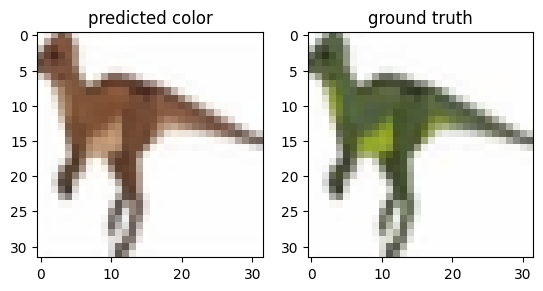

In [ ]:
import random 
model.eval()

index = random.randint(0,len(test_data))
input, label = test_data[index]
rgb_label = to_rgb(input, label)

input = input.to(device)
output = model(input.unsqueeze(0)).squeeze()
print(output.shape)
rgb_pred = to_rgb(input.cpu(), output.cpu())

input.shape, label.shape, output.shape
rgb_pred.shape, rgb_label.shape
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2)  


axes[0].imshow(rgb_pred)
axes[0].set_title('predicted color')

axes[1].imshow(rgb_label)
axes[1].set_title('ground truth')
print(index)


Text(0.5, 1.0, 'ground truth')

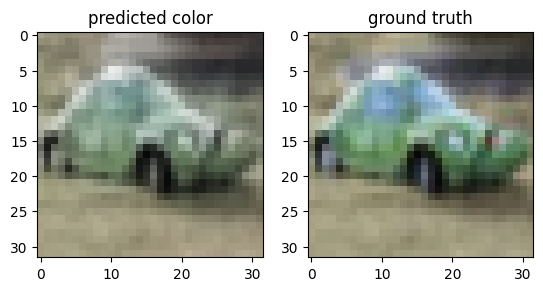

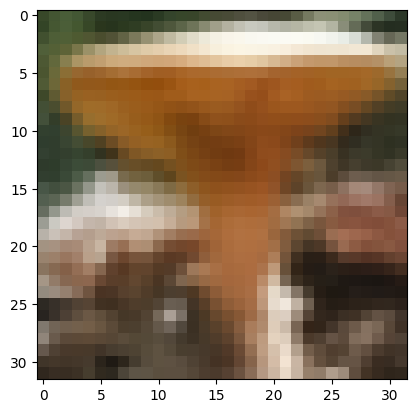

In [ ]:
plt.imshow(rgb_pred)

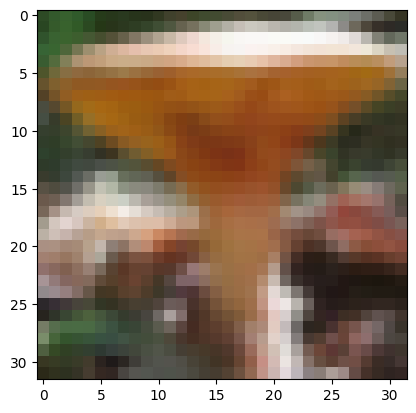

In [ ]:
plt.imshow(rgb_label)